In [1]:
import numpy as np
import tensorflow as tf
import random
from tensorflow.keras.applications import ResNet50, VGG16, MobileNetV2 ,InceptionV3,DenseNet121
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Concatenate, Dense, Dropout,Average, BatchNormalization,Multiply
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB1


In [3]:
np.random.seed(50)
tf.random.set_seed(50)
random.seed(50)

In [4]:
import os
import shutil
import random
from sklearn.model_selection import train_test_split

# Ratios for splitting
train_ratio = 0.6
test_ratio = 0.2
val_ratio = 0.2

# Base directory
base_path = r'/kaggle/input/kmc-grading-liver/KMC_LiverGrading'
output_base_path = '/kaggle/working/'

# Valid image extensions
valid_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tif')

# Function to split and copy images
def split_and_copy_images(class_name, class_path):
    files = os.listdir(class_path)
    images = [os.path.join(class_path, img) for img in files if img.lower().endswith(valid_extensions)]

    if len(images) == 0:
        print(f"No images found in {class_path}. Skipping this directory.")
        return

    train_images, test_val_images = train_test_split(images, test_size=(test_ratio + val_ratio), random_state=42)
    val_images, test_images = train_test_split(test_val_images, test_size=(test_ratio / (test_ratio + val_ratio)), random_state=42)

    split_images_dict = {
        'train': train_images,
        'test': test_images,
        'val': val_images
    }

    for split in split_images_dict:
        split_class_path = os.path.join(output_base_path, split, class_name)
        os.makedirs(split_class_path, exist_ok=True)
        for img in split_images_dict[split]:
            shutil.copy(img, split_class_path)

# Main processing
classes = os.listdir(r"/kaggle/input/kmc-grading-liver/KMC_LiverGrading")
for class_name in classes:
    class_path = os.path.join(base_path, class_name)
    split_and_copy_images(class_name, class_path)

In [5]:
train_dir = '/kaggle/working/train'
val_dir = '/kaggle/working/val'
test_dir = '/kaggle/working/test'

In [6]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2],
    channel_shift_range=0.2,
    fill_mode='nearest'
)


val_datagen = ImageDataGenerator(rescale=1.0/255.0)


test_datagen = ImageDataGenerator(rescale=1.0/255.0)

In [7]:
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=32, class_mode='categorical',shuffle=True)
val_generator = val_datagen.flow_from_directory(val_dir, target_size=(224, 224), batch_size=32, class_mode='categorical',shuffle=False)
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=32, class_mode='categorical',shuffle=False)

Found 1696 images belonging to 4 classes.
Found 566 images belonging to 4 classes.
Found 567 images belonging to 4 classes.


In [8]:

mobilenet = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))#311
inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))#249
densenet = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))#311
mobilenet.trainable = True
inception.trainable = True
densenet.trainable = True

for layer in densenet.layers[:311]:
   layer.trainable=False
for layer in mobilenet.layers[:311]:
   layer.trainable=False
for layer in inception.layers[:249]:
   layer.trainable=False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
from tensorflow.keras import layers, models
from tensorflow.keras import layers, models
def apply_attention(inputs):
    attention_probs = Dense(1, activation='sigmoid')(inputs)
    attention_mul = Multiply()([inputs, attention_probs])
    return attention_mul


def attention_block1(inputs):
    filters = inputs.shape[-1]
    attention = layers.Conv2D(filters, kernel_size=1, padding='same')(inputs)
    attention = layers.Activation('relu')(attention)
    attention = layers.Conv2D(filters, kernel_size=1, padding='same')(attention)
    attention = layers.Activation('sigmoid')(attention)
    output = layers.multiply([inputs, attention])
    return output

# def attention_block2(inputs):
#     filters = inputs.shape[-1]
#     attention = layers.Conv2D(filters, kernel_size=1, padding='same')(inputs)
#     attention = layers.Activation('relu')(attention)
#     attention = layers.Conv2D(filters, kernel_size=1, padding='same')(attention)
#     attention = layers.Activation('sigmoid')(attention)
#     output = layers.multiply([inputs, attention])
#     return output

In [10]:
inputs = Input(shape=(224, 224, 3))

mobilenet_output = mobilenet(inputs)
inception_output = inception(inputs)
densenet_output = densenet(inputs)


mobilenet_output = attention_block1(mobilenet_output)
mobilenet_output = apply_attention(mobilenet_output)

inception_output = attention_block1(inception_output)
inception_output = apply_attention(inception_output)

densenet_output = attention_block1(densenet_output)
densenet_output = apply_attention(densenet_output)


mobilenet_output = GlobalAveragePooling2D()(mobilenet_output)
inception_output = GlobalAveragePooling2D()(inception_output)
densenet_output = GlobalAveragePooling2D()(densenet_output)

concatenated = Concatenate()([mobilenet_output,inception_output,densenet_output])
x = Dense(1024, activation='relu')(concatenated)
x = Dropout(0.5)(x)
output = Dense(train_generator.num_classes, activation='softmax')(x)

ensemble_model = Model(inputs, output)

In [11]:
import tensorflow as tf

# Define callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='best_model_ensemble.keras',
        save_best_only=True,
        monitor='val_loss',
        mode='min'
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        mode='min',
        restore_best_weights=True
    ),
   
]

# Compile the model
ensemble_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

# Train the model with callbacks
history = ensemble_model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=callbacks
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


53/53 ━━━━━━━━━━━━━━━━━━━━ 158s 1s/step - accuracy: 0.6519 - loss: 0.7746 - val_accuracy: 0.7968 - val_loss: 1.6344
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 547ms/step - accuracy: 0.8917 - loss: 0.2484 - val_accuracy: 0.8834 - val_loss: 0.5036
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 550ms/step - accuracy: 0.9376 - loss: 0.1471 - val_accuracy: 0.9240 - val_loss: 0.2711
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 555ms/step - accuracy: 0.9083 - loss: 0.1691 - val_accuracy: 0.9435 - val_loss: 0.1485
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 29s 479ms/step - accuracy: 0.9453 - loss: 0.1356 - val_accuracy: 0.8887 - val_loss: 0.5300
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 29s 479ms/step - accuracy: 0.9469 - loss: 0.1396 - val_accuracy: 0.8975 - val_loss: 0.3192
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 29s 477ms/step - accuracy: 0.9521 - loss: 0.1245 - val_accuracy: 0.9346 - val_loss: 0.1863
Epoch 8/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 564ms/step - accuracy: 0.9534 - loss: 0.1135 - val_accuracy: 0.9770 

In [13]:
test_loss, test_acc = ensemble_model.evaluate(test_generator)
print('Test accuracy:', test_acc)

18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - accuracy: 0.9710 - loss: 0.0991
Test accuracy: 0.9700176119804382


In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
import seaborn as sns

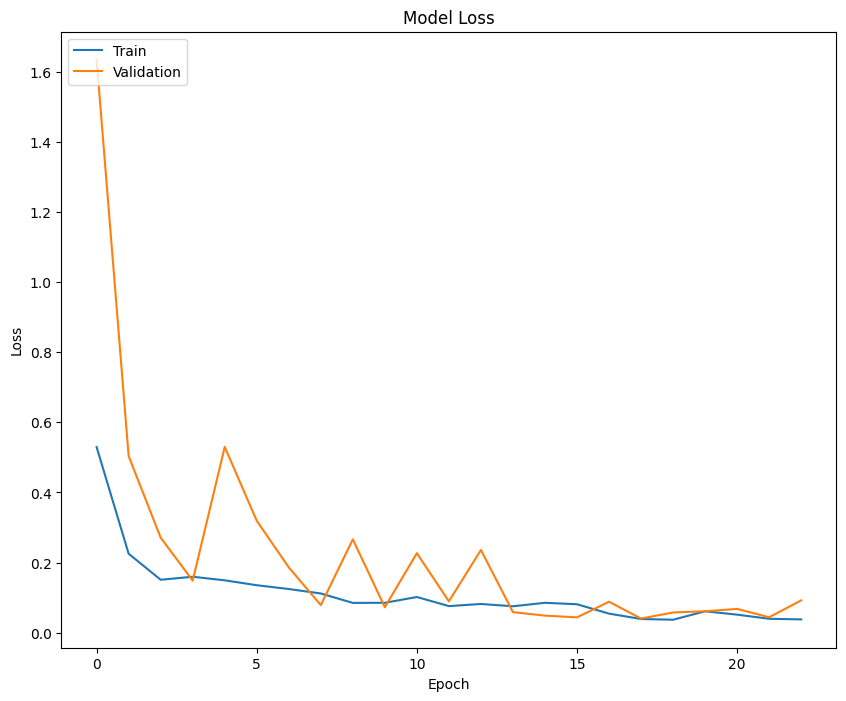

In [15]:
# Plot training & validation loss values
plt.figure(figsize=(10, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

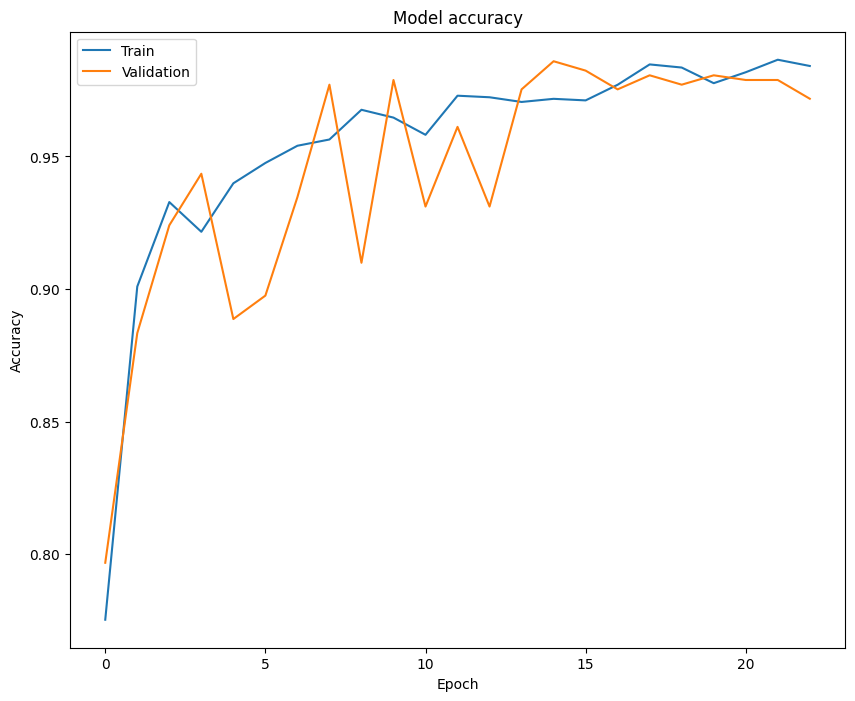

In [16]:
# Plot training & validation accuracy values
plt.figure(figsize=(10, 8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

18/18 ━━━━━━━━━━━━━━━━━━━━ 31s 987ms/step
Classification Report (Rounded to 4 Decimal Places)
grade0: precision: 1.0000, recall: 1.0000, f1-score: 1.0000, support: 130.0000
grade1: precision: 0.9848, recall: 0.9028, f1-score: 0.9420, support: 144.0000
grade2: precision: 0.9130, recall: 0.9800, f1-score: 0.9453, support: 150.0000
grade3: precision: 0.9931, recall: 1.0000, f1-score: 0.9965, support: 143.0000
accuracy: 0.9700
macro avg: precision: 0.9727, recall: 0.9707, f1-score: 0.9710, support: 567.0000
weighted avg: precision: 0.9714, recall: 0.9700, f1-score: 0.9699, support: 567.0000


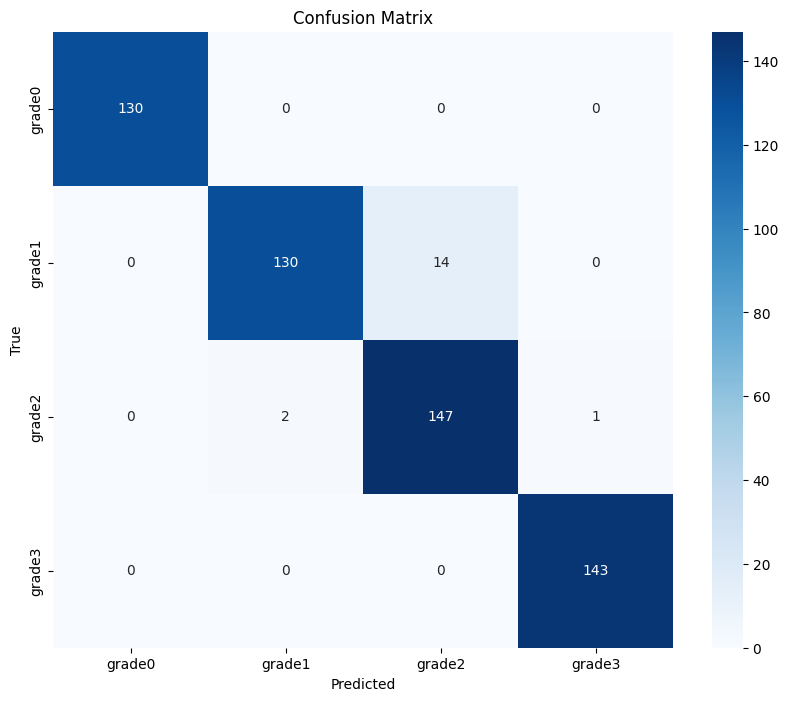

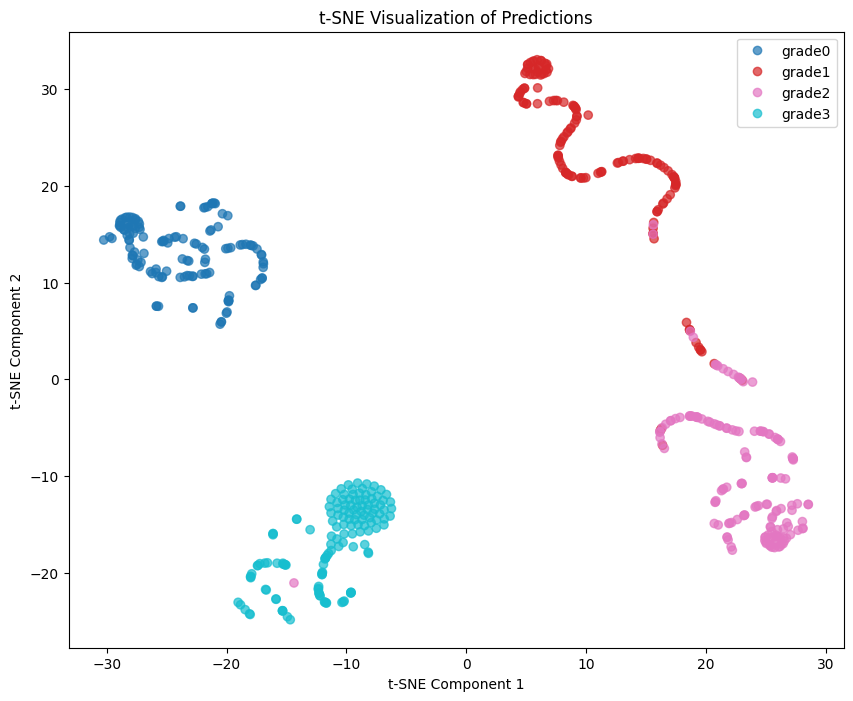

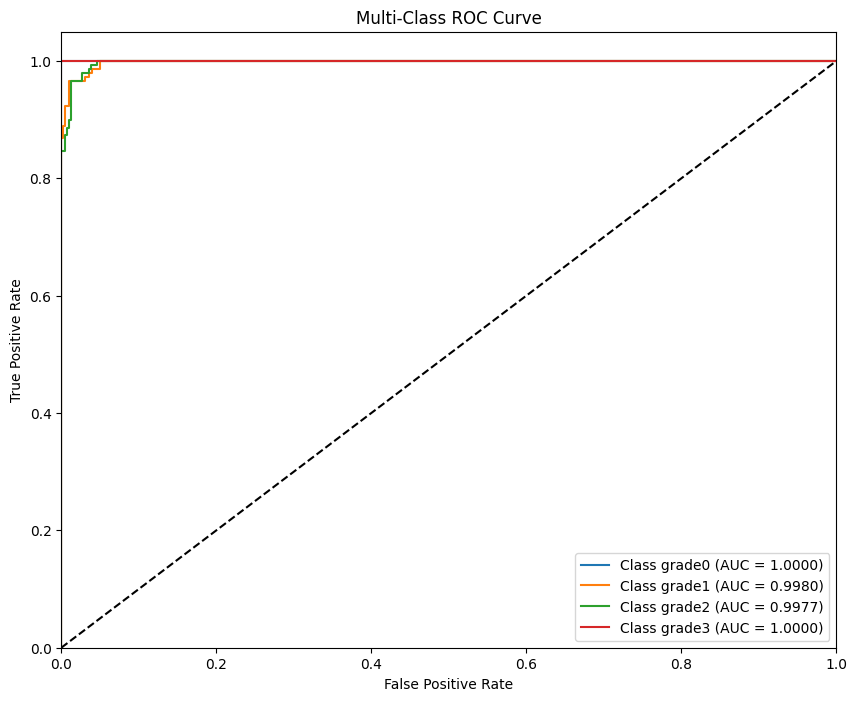

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.manifold import TSNE
from sklearn.preprocessing import label_binarize

# Generate predictions
Y_pred = ensemble_model.predict(test_generator)
y_true = test_generator.classes
y_pred = np.argmax(Y_pred, axis=1)

# Classification report
report = classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys(), output_dict=True)
print('Classification Report (Rounded to 4 Decimal Places)')
for label, metrics in report.items():
    if isinstance(metrics, dict):  # Avoid 'accuracy' key which is a single float
        print(f"{label}: " + ", ".join(f"{k}: {v:.4f}" for k, v in metrics.items()))
    else:
        print(f"{label}: {metrics:.4f}")

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# t-SNE visualization
tsne = TSNE(n_components=2, random_state=42)
tsne_embeddings = tsne.fit_transform(Y_pred)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=y_true, cmap='tab10', alpha=0.7)
plt.legend(handles=scatter.legend_elements()[0], labels=test_generator.class_indices.keys())
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE Visualization of Predictions")
plt.show()

# ROC Curve for Multi-Class Classification
n_classes = len(test_generator.class_indices)
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], Y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {list(test_generator.class_indices.keys())[i]} (AUC = {roc_auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--')  # Random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [16]:
ensemble_model.layers

[<InputLayer name=input_layer_3, built=True>,
 <Functional name=mobilenetv2_1.00_224, built=True>,
 <Functional name=inception_v3, built=True>,
 <Functional name=densenet121, built=True>,
 <Conv2D name=conv2d_94, built=True>,
 <Conv2D name=conv2d_96, built=True>,
 <Conv2D name=conv2d_98, built=True>,
 <Activation name=activation_94, built=True>,
 <Activation name=activation_96, built=True>,
 <Activation name=activation_98, built=True>,
 <Conv2D name=conv2d_95, built=True>,
 <Conv2D name=conv2d_97, built=True>,
 <Conv2D name=conv2d_99, built=True>,
 <Activation name=activation_95, built=True>,
 <Activation name=activation_97, built=True>,
 <Activation name=activation_99, built=True>,
 <Multiply name=multiply, built=True>,
 <Multiply name=multiply_2, built=True>,
 <Multiply name=multiply_4, built=True>,
 <Dense name=dense, built=True>,
 <Dense name=dense_1, built=True>,
 <Dense name=dense_2, built=True>,
 <Multiply name=multiply_1, built=True>,
 <Multiply name=multiply_3, built=True>,
 <

In [17]:
from tensorflow.keras.models import Model

inputs = ensemble_model.input

mobilenet_output = ensemble_model.get_layer('global_average_pooling2d').output
inception_output = ensemble_model.get_layer('global_average_pooling2d_1').output
densenet_output = ensemble_model.get_layer('global_average_pooling2d_2').output

feature_extractor_model = Model(inputs=inputs, outputs=[mobilenet_output, inception_output, densenet_output])

mobilenet_features, inception_features, densenet_features = feature_extractor_model.predict(train_generator)

53/53 ━━━━━━━━━━━━━━━━━━━━ 37s 436ms/step


In [18]:
mobilenet_features, inception_features, densenet_features = feature_extractor_model.predict(val_generator)

18/18 ━━━━━━━━━━━━━━━━━━━━ 17s 993ms/step


In [19]:
print(mobilenet_output)
print(densenet_output)
print(inception_output)

<KerasTensor shape=(None, 1280), dtype=float32, sparse=False, name=keras_tensor_917>
<KerasTensor shape=(None, 1024), dtype=float32, sparse=False, name=keras_tensor_919>
<KerasTensor shape=(None, 2048), dtype=float32, sparse=False, name=keras_tensor_918>


In [20]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='best_model_ensemble_economics.keras',
        save_best_only=True,
        monitor='val_loss',
        mode='min'
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        mode='min',
        restore_best_weights=True
    ),
    tf.keras.callbacks.TensorBoard(log_dir='./logs')
]


In [21]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Multiply, Concatenate, Dropout, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2


# Custom Layer to calculate the Gini Coefficient
class GiniCoefficient(Layer):
    def call(self, inputs):
        inputs = tf.keras.layers.Flatten()(inputs)
        sorted_inputs = tf.sort(inputs, axis=-1)
        cumsum = tf.cumsum(sorted_inputs, axis=-1)
        n = tf.cast(tf.shape(inputs)[-1], tf.float32)
        gini = 1 - 2 * tf.reduce_sum((n + 1 - tf.range(1, n + 1, dtype=tf.float32)) * sorted_inputs, axis=-1) / (n * tf.reduce_sum(sorted_inputs, axis=-1))
        gini = tf.clip_by_value(gini, 1e-7, 1.0)  # Avoid NaN values by clipping
        gini = tf.expand_dims(gini, axis=-1)  # Ensure Gini coefficient has the correct shape
        return gini

# Custom Layer for Feature Fusion using Gini Coefficients
class FeatureFusion(Layer):
    def __init__(self):  # Corrected from _init_ to __init__
        super(FeatureFusion, self).__init__()
        self.alpha = self.add_weight(name='alpha', shape=(1,), initializer='uniform', trainable=True, regularizer=tf.keras.regularizers.l2(0.01))
        self.beta = self.add_weight(name='beta', shape=(1,), initializer='uniform', trainable=True, regularizer=tf.keras.regularizers.l2(0.01))
        self.gamma = self.add_weight(name='gamma', shape=(1,), initializer='uniform', trainable=True, regularizer=tf.keras.regularizers.l2(0.01))

    def call(self, inputs):
        mobilenet_output, inception_output, densenet_output = inputs

        # Calculate Gini Coefficients
        gini_mobilenet = GiniCoefficient()(mobilenet_output)
        gini_inception = GiniCoefficient()(inception_output)
        gini_densenet = GiniCoefficient()(densenet_output)

        # Normalize Gini coefficients
        gini_sum = gini_mobilenet + gini_inception + gini_densenet
        gini_mobilenet = gini_mobilenet / gini_sum
        gini_inception = gini_inception / gini_sum
        gini_densenet = gini_densenet / gini_sum

        # Apply softmax to alpha, beta, gamma to ensure they sum to 1
        weights = tf.concat([self.alpha, self.beta, self.gamma], axis=0)
        alpha, beta, gamma = tf.split(tf.nn.softmax(weights), num_or_size_splits=3)

        # Feature fusion using weighted sum
        fused_features = (gini_mobilenet * alpha) * mobilenet_output + (gini_inception * beta) * inception_output + (gini_densenet * gamma) * densenet_output
        return fused_features

    def compute_output_shape(self, input_shape):
        return input_shape[0]


# Using the feature extractor model
inputs = feature_extractor_model.input

# Extract features using the feature_extractor_model
mobilenet_features, inception_features, densenet_features = feature_extractor_model.output

# Align dimensions of feature vectors
target_dim = 1024 # Target dimension for the feature vectors
mobilenet_output_aligned = Dense(target_dim)(mobilenet_features)
inception_output_aligned = Dense(target_dim)(inception_features)
densenet_output_aligned = Dense(target_dim)(densenet_features)

# Create the final model using the FeatureFusion layer
fused_features = FeatureFusion()([mobilenet_output_aligned, inception_output_aligned, densenet_output_aligned])

# Add final dense and dropout layers
x = Dense(1024, activation='relu')(fused_features)  # Increased number of neurons
x = Dropout(0.5)(x)
output = Dense(train_generator.num_classes, activation='softmax')(x)  # Adjust according to your number of classes
# Adjust according to your number of classes

final_model = Model(inputs=inputs, outputs=output)

# Compile the final model
final_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=['accuracy'])

# Early stopping and model checkpointing
#early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
#model_checkpoint = ModelCheckpoint('best_model-economics.keras', monitor='val_accuracy', save_best_only=True)

# Train the final model with callbacks
#history = final_model.fit(train_generator, epochs=50, validation_data=val_generator, callbacks=callbacks)

In [22]:
history1 = final_model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=callbacks
)

Epoch 1/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - accuracy: 0.8356 - loss: 0.5034 - val_accuracy: 0.8834 - val_loss: 0.4283
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 551ms/step - accuracy: 0.9496 - loss: 0.1570 - val_accuracy: 0.9523 - val_loss: 0.2014
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 29s 479ms/step - accuracy: 0.9507 - loss: 0.1257 - val_accuracy: 0.9611 - val_loss: 0.2678
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 29s 477ms/step - accuracy: 0.9564 - loss: 0.1182 - val_accuracy: 0.9223 - val_loss: 0.5483
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 553ms/step - accuracy: 0.9439 - loss: 0.1607 - val_accuracy: 0.9205 - val_loss: 0.1653
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 551ms/step - accuracy: 0.9415 - loss: 0.1477 - val_accuracy: 0.9700 - val_loss: 0.1120
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 29s 478ms/step - accuracy: 0.9648 - loss: 0.1209 - val_accuracy: 0.9452 - val_loss: 0.1218
Epoch 8/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 29s 478ms/step - accuracy: 0.9593 - loss: 0.1030 - val_accura

In [27]:
test_loss, test_acc = final_model.evaluate(test_generator)
print('Test accuracy:', test_acc)

18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - accuracy: 0.9849 - loss: 0.0519
Test accuracy: 0.9823633432388306


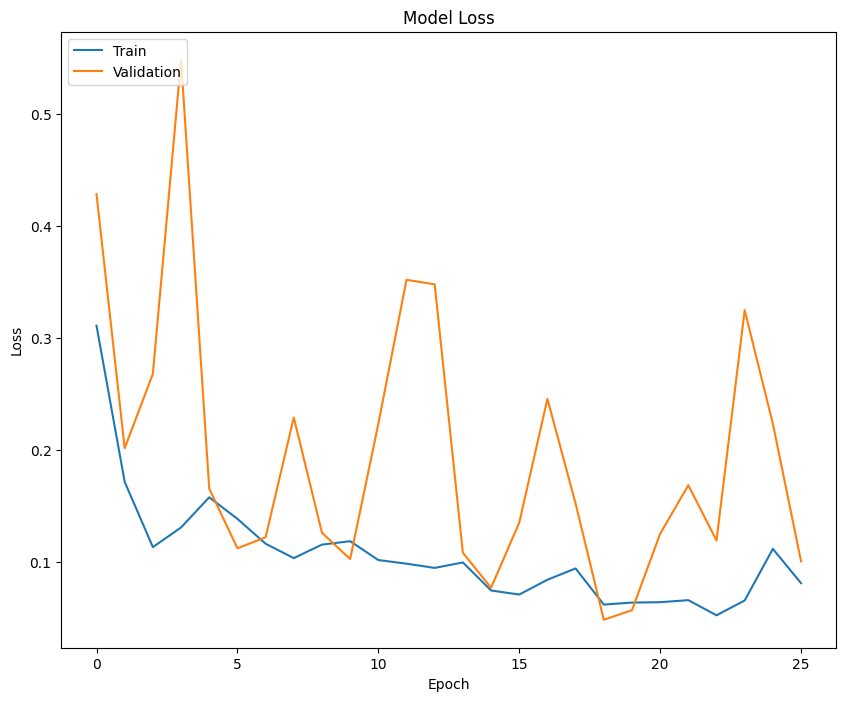

In [24]:
# Plot training & validation loss values
plt.figure(figsize=(10, 8))
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

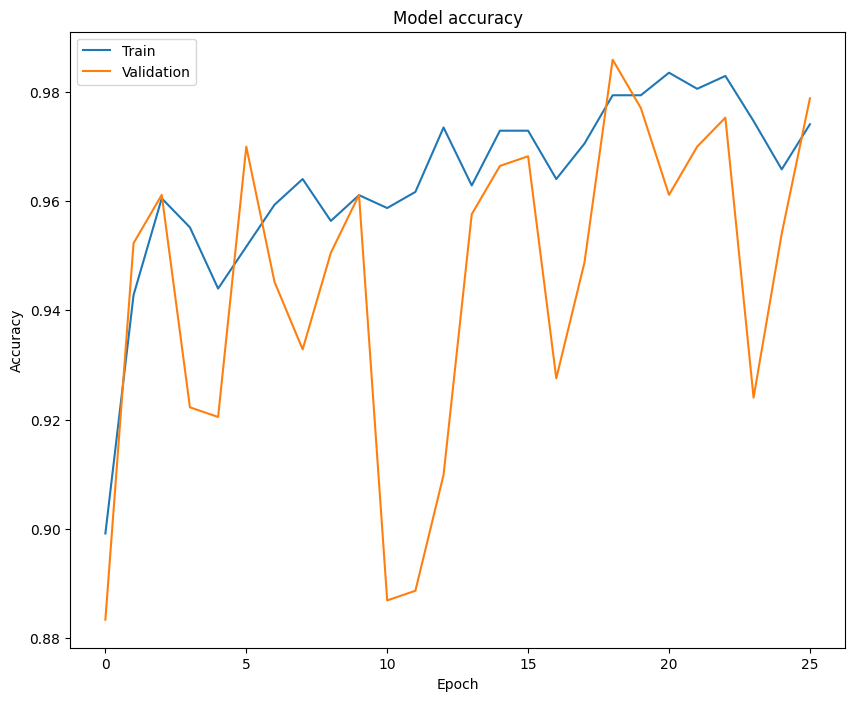

In [25]:
# Plot training & validation accuracy values
plt.figure(figsize=(10, 8))
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

18/18 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step 
Classification Report (Rounded to 4 Decimal Places)
grade0: precision: 1.0000, recall: 1.0000, f1-score: 1.0000, support: 130.0000
grade1: precision: 0.9787, recall: 0.9583, f1-score: 0.9684, support: 144.0000
grade2: precision: 0.9605, recall: 0.9733, f1-score: 0.9669, support: 150.0000
grade3: precision: 0.9931, recall: 1.0000, f1-score: 0.9965, support: 143.0000
accuracy: 0.9824
macro avg: precision: 0.9831, recall: 0.9829, f1-score: 0.9830, support: 567.0000
weighted avg: precision: 0.9824, recall: 0.9824, f1-score: 0.9823, support: 567.0000


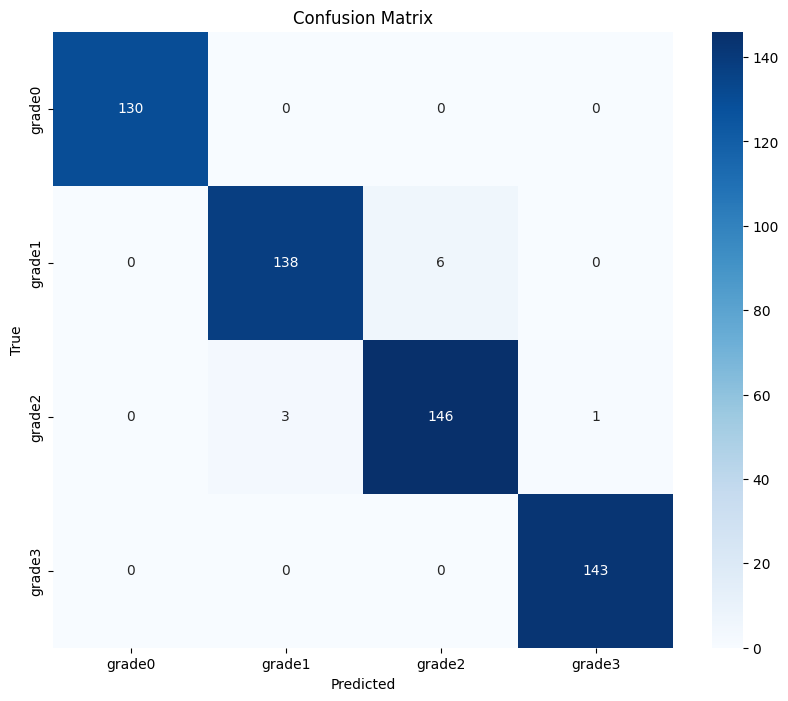

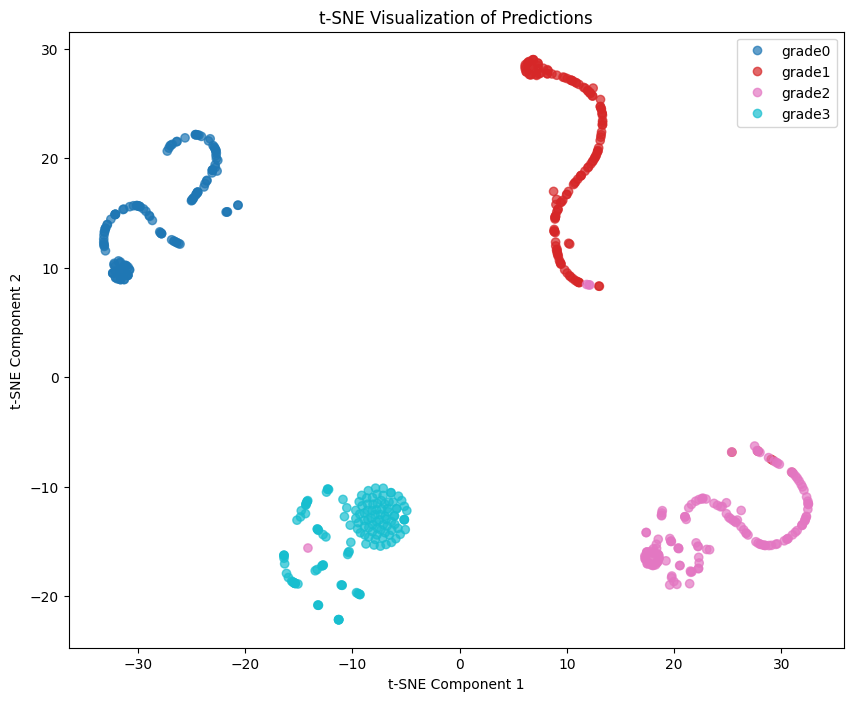

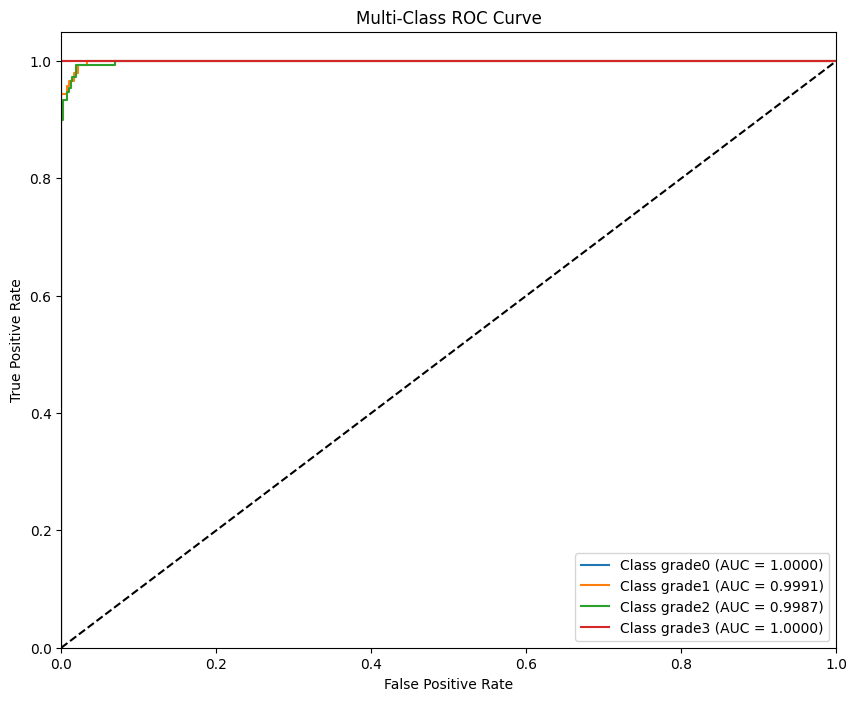

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.manifold import TSNE
from sklearn.preprocessing import label_binarize

# Generate predictions
Y_pred = final_model.predict(test_generator)
y_true = test_generator.classes
y_pred = np.argmax(Y_pred, axis=1)

# Classification report
report = classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys(), output_dict=True)
print('Classification Report (Rounded to 4 Decimal Places)')
for label, metrics in report.items():
    if isinstance(metrics, dict):  # Avoid 'accuracy' key which is a single float
        print(f"{label}: " + ", ".join(f"{k}: {v:.4f}" for k, v in metrics.items()))
    else:
        print(f"{label}: {metrics:.4f}")

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# t-SNE visualization
tsne = TSNE(n_components=2, random_state=42)
tsne_embeddings = tsne.fit_transform(Y_pred)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=y_true, cmap='tab10', alpha=0.7)
plt.legend(handles=scatter.legend_elements()[0], labels=test_generator.class_indices.keys())
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE Visualization of Predictions")
plt.show()

# ROC Curve for Multi-Class Classification
n_classes = len(test_generator.class_indices)
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], Y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {list(test_generator.class_indices.keys())[i]} (AUC = {roc_auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--')  # Random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc='lower right')
plt.show()
